# Test 9

Various GS from Simulated Annealing

Field: 8mT along the x axis

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import random
from math import isclose

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore some messages from pandas

from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice
#from auxiliary import *
import auxiliary as aux
#from montecarlo_tools import *
import montecarlo_tools as mc
from IPython.display import clear_output

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/home/leogabac/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.grid'] = False

In [3]:
params = {
    "particle_radius":5*ureg.um,
    "particle_susceptibility":0.0576,
    "particle_diffusion":0.125*ureg.um**2/ureg.s,
    "particle_temperature":300*ureg.K,
    "particle_density":1000*ureg.kg/ureg.m**3,

    "trap_sep":10*ureg.um,
    "trap_height":4*ureg.pN*ureg.nm,
    "trap_stiffness":1e-3*ureg.pN/ureg.nm,
    "height_spread":0,
    "susceptibility_spread":0,
    "isperiodic":True,
    
    "total_time":120*ureg.s,
    "framespersec":20*ureg.Hz,
    "dt":10*ureg.ms,
    "max_field":7*ureg.mT,
    "sim_temp":300*ureg.K,
    "sim_dipole_cutoff":40*ureg.um,
    
    "lattice_constant":30*ureg.um,
    "size" : 10
}

In [4]:
# Definition of colloids

sp = ice.spins()

rho = params["particle_radius"]
L = params["lattice_constant"]
N = params["size"]

# Create simulation objects
sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

particle = ice.particle(radius = rho,
            susceptibility = params["particle_susceptibility"],
            diffusion = params["particle_diffusion"],
            temperature = params["particle_temperature"],
            density = params["particle_density"])

trap = ice.trap(trap_sep = params["trap_sep"],
            height = params["trap_height"],
            stiffness = params["trap_stiffness"])

col = ice.colloidal_ice(sp, particle, trap,
            height_spread = params["height_spread"], 
            susceptibility_spread = params["susceptibility_spread"],
            periodic = params["isperiodic"])


col.randomize()
col.region = np.array([[0,0,-3*(rho/L/N).magnitude],[1,1,3*(rho/L/N).magnitude]])*N*L

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))
col.display(ax)

In [6]:
boltzmann_constant = 1.380649e-23 * ureg.newton*ureg.meter/ureg.kelvin # N m/K

In [7]:
E = col.calculate_energy(B=[0,0,8]*ureg.mT)
T = 300*ureg.kelvin
(E/boltzmann_constant/T).to_base_units().magnitude

80757.67925725333

In [ ]:
save_each = 100
for k in range(1000):
    if k%save_each == 0:
        print(k)

# Simulated Annealing

In [8]:
def simulation(colloid, field, data_path, niter = 100, save_each=100):
    
    # Initialize stuff
    energies = np.zeros(niter)

    # Save initial state
    colloid.to_ctrj().to_csv(data_path + "trj0.csv")

    # No sé por qué debo de calcular esto primero xd
    Eold = colloid.calculate_energy(B = field)
    energies[0] = Eold.magnitude

    T = 300

    for k in tqdm(range(1,niter)):
        
        newcolloid = colloid.copy(deep = True)
        newcolloid = mc.flip_colloids(newcolloid,amount=3)
        newcolloid = mc.flip_loop(newcolloid,a=30,size=10)

        Enew = newcolloid.calculate_energy(B=field)
        dE = Enew - Eold

        # Accept or reject the change
        if mc.is_accepted(dE,T,kB=boltzmann_constant):
            colloid = newcolloid.copy(deep = True)
            Eold = Enew
            energies[k] = Eold.magnitude
        else:
            energies[k] = Eold.magnitude
        
        
        if k%save_each==0:
            currentFile = f"trj{k}.csv"
            colloid.to_ctrj().to_csv(data_path + currentFile)
        
        T = 0.9*T
    
    currentFile = f"trj{niter-1}.csv"
    colloid.to_ctrj().to_csv(data_path + currentFile)
    return colloid, energies


In [9]:
angles_to_complete = [0,30,60,90]
angles_to_complete 

[0, 30, 60, 90]

In [12]:
for theta in angles_to_complete:

    clear_output(wait=True)
    print(f"========== {theta} ==========")
    # making folders and shit
    angle = theta*ureg("deg")
    rangle = angle.to("rad")
    main_path = "../data/test9/"
    angle_path = main_path+f"mc/{angle.magnitude}/"

    try: 
        os.mkdir(angle_path)
    except:
        pass

    # making the field
    B0 = 10*ureg.mT
    field = [np.sin(rangle.magnitude),0,np.cos(rangle.magnitude)]*B0

    np.random.seed(0)
    final_state, data = simulation(col, field, angle_path, niter=15000, save_each=1000)

    pd.DataFrame(data).to_csv(angle_path + "data.csv")

========== 90 ==========


100%|██████████| 14999/14999 [35:27<00:00,  7.05it/s]


# Making a nice figure

In [13]:
def load_saved_state(main_path,folder,last = 14999):
    file = f"/trj{last}.csv"
    return pd.read_csv(main_path+folder+file,index_col=0)

def load_saved_energy(main_path,folder):
    file = "/data.csv"
    return pd.read_csv(main_path+folder+file,index_col=0)["0"].to_list()

In [14]:
main_path = "../data/test9/mc/"
angles = os.listdir(main_path)

final_states = { directory:aux.get_colloids_from_ctrj(load_saved_state(main_path,directory),particle,trap,rho,L,N) for directory in tqdm(angles) }
all_energies = { directory:load_saved_energy(main_path,directory) for directory in angles }

100%|██████████| 4/4 [00:00<00:00,  6.71it/s]


In [33]:
vrt = dict()
for key,col in final_states.items():
    v = ice.vertices()
    v = v.colloids_to_vertices(col)
    vrt[key] = v

100%|██████████| 200/200 [00:00<00:00, 263.00it/s]


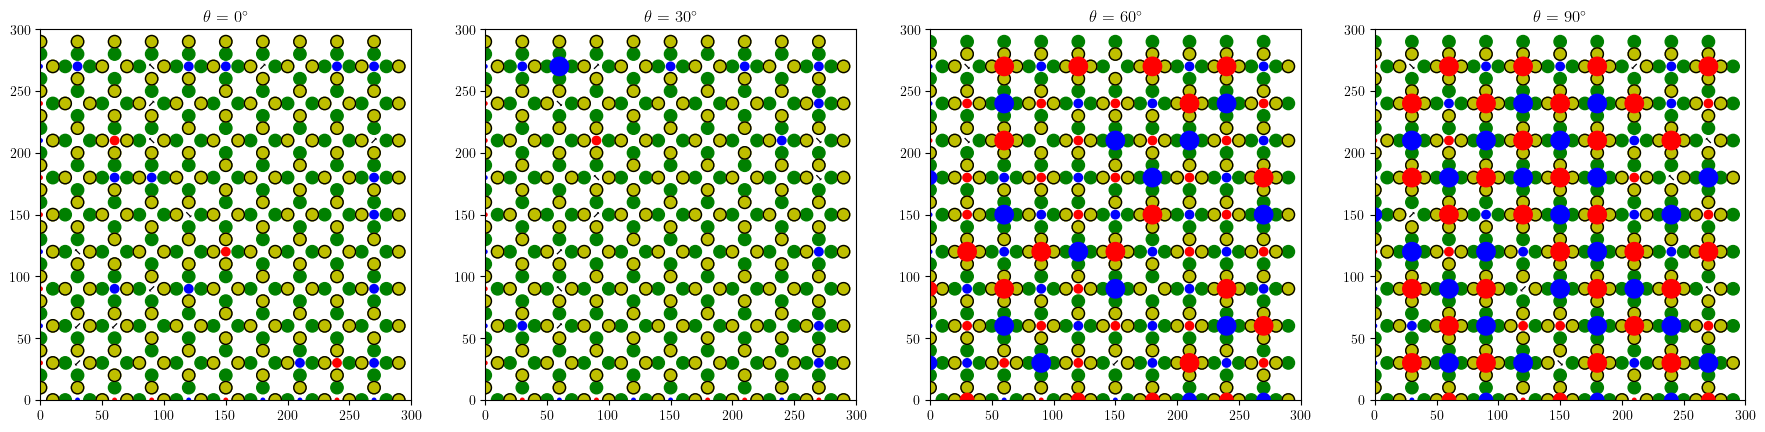

In [37]:
fig, axes = plt.subplots(1,4,figsize=(22,5))

ax = axes[0]
key = '0'
col = final_states[key]
v = vrt[key]
col.display(ax)
v.display(ax)
ax.set_title("$\\theta$ = 0$^\\circ$")

ax = axes[1]
key = '30'
col = final_states[key]
v = vrt[key]
col.display(ax)
v.display(ax)
ax.set_title("$\\theta$ = 30$^\\circ$")



ax = axes[2]
key = '60'
col = final_states[key]
v = vrt[key]
col.display(ax)
v.display(ax)
ax.set_title("$\\theta$ = 60$^\\circ$")

ax = axes[3]
key = '90'
col = final_states[key]
v = vrt[key]
col.display(ax)
v.display(ax)
ax.set_title("$\\theta$ = 90$^\\circ$")

fig.savefig("../data/test9/states.pdf")
fig.savefig("../data/test9/states.jpeg",dpi=300)

plt.show()

# Plotting all states

In [95]:
def load_saved_state(main_path,folder):
    file = "/trj99.csv"
    return pd.read_csv(main_path+folder+file,index_col=0)

def load_saved_energy(main_path,folder):
    file = "/data.csv"
    return pd.read_csv(main_path+folder+file,index_col=0)["0"].to_list()

In [ ]:
main_path = "../data/test9/mc/"
angles = os.listdir(main_path)

final_states = { directory:aux.get_colloids_from_ctrj(load_saved_state(main_path,directory),particle,trap,rho,L,N) for directory in tqdm(angles) }
all_energies = { directory:load_saved_energy(main_path,directory) for directory in angles }

In [ ]:
fig_path = "../data/test9/figures/"
for cur_angle in angles:
    clear_output(wait=True)

    print(f"Doing... {cur_angle} degrees")

    cur_state = final_states[cur_angle]
    cur_energy = all_energies[cur_angle]

    string = "$\\theta$ = "+cur_angle+"$^\circ$"

    fig, axes = plt.subplots(1,2,figsize=(12,5))
    ax = axes[0]
    v = ice.vertices()
    v = v.colloids_to_vertices(cur_state)
    cur_state.display(ax)
    v.display(ax)

    ax = axes[1]
    ax.plot(all_energies[cur_angle])
    ax.set_xlabel("MC Steps")
    ax.set_ylabel("Energy \, [pN$\cdot$nm]")
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)

    fig.text(0.5,0.9,string,ha='center',fontsize=20)

    file = cur_angle+".png"
    fig.savefig(fig_path+file)

    plt.close(fig)